# Haar interferometer and multimode squeezed vacuum

We test the boson sampling operator (no training) 
on squeezed states, and 
propagating in a Haar random medium

nonlinearxwaves@gmail.com<br>
@created 30 gennaio 2021<br>
@version 4 may 2023<br>

In [1]:
import numpy as np
from thqml import phasespace as ps
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import itertools as it

2023-05-04 05:42:51.094637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-04 05:42:51.094701: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [3]:
tf.keras.backend.clear_session()

In [4]:
np.set_printoptions(precision=2)

Check GPU

In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2023-05-04 05:43:02.735007: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-04 05:43:02.735032: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-04 05:43:02.735054: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x1): /proc/driver/nvidia/version does not exist


## Dimension

In [6]:
N = 12

In [7]:
n=np.floor_divide(N,2)

In [8]:
nmodes = int(n)

In [9]:
print('Number of modes '+repr(n))

Number of modes 6


## Build vacuum by the Gaussian state

In [10]:
vacuum = ps.VacuumLayer(N)

2023-05-04 05:44:09.180593: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Parameter for squeezing

In [11]:
r_np=0.88;
theta_np=np.pi/4;

## Random medium (Haar measure)

In [12]:
HAAR=ps.HaarLayerConstant(N)

## Build the model

In [13]:
xin = tf.keras.layers.Input(N)
x1, a1 = HAAR(xin)
for j in range(nmodes):
    x1, a1 = ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=j)(x1,a1)
chir, chii = vacuum(x1, a1)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 haar_layer_constant (HaarLayer  [(None, 12),        0           ['input_1[0][0]']                
 Constant)                       (12, 1)]                                                         
                                                                                                  
 single_mode_squeezer_layer (Si  [(None, 12),        2           ['haar_layer_constant[0][0]',    
 ngleModeSqueezerLayer)          (12, 1)]                         'haar_layer_constant[0][1]']    
                                                                                              

In [16]:
tf.keras.utils.plot_model(
    model, to_file='modelHaar.pdf', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None, show_layer_activations=False
)

# Evaluate the covariance

In [18]:
%%time
cov_layer = ps.covariance(N)
covariance_matrix, mean_R, hessian = cov_layer(chir,chii, model)
squeezed_cov = tf.keras.Model(inputs = xin, outputs=[covariance_matrix, mean_R, hessian])
xtrain = np.random.rand(1, N)-0.5
cov0,d0, hessian0=squeezed_cov(xtrain); print(d0); tf.print(cov0)

tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(1, 12), dtype=float32)
[[4.65378094 0.4662323 1.06614268 ... 0.549121916 -0.445810556 -0.714445472]
 [0.46623221 1.33070135 -0.656516194 ... 0.713902414 -0.714445531 0.445810407]
 [1.06614268 -0.656516194 4.19178915 ... -1.00861049 0.126099765 0.950789332]
 ...
 [0.549122 0.713902473 -1.00861061 ... 2.00609708 0.12736474 1.23721838]
 [-0.445810467 -0.714445591 0.126099661 ... 0.12736468 3.13234067 -0.0125622675]
 [-0.714445591 0.445810378 0.950789154 ... 1.23721838 -0.0125621883 2.8521409]]
CPU times: user 1.38 s, sys: 11.8 ms, total: 1.39 s
Wall time: 1.39 s


# Evaluate the Qtransform with calculated covariance and displacement

In [19]:
Qrho = ps.QTransform(cov0, d0)

# Test the Pr operator 

Probability of zero photon

In [20]:
%%time
ps.Pr([0]*nmodes, Qrho)

CPU times: user 7.78 ms, sys: 0 ns, total: 7.78 ms
Wall time: 9.49 ms


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.13]], dtype=float32)>

# Generate all the possible photon patterns assuming one photon per mode

In [21]:
def patterns(nphotons, nmodes):
    l1=[0]*nmodes
    for j in range(nphotons):
        l1[j]=1
    nlist=it.permutations(l1,nmodes)
    ln=list(nlist)
    ln.sort()
    # remove duplicates
    ln=list(ln for ln,_ in it.groupby(ln))
    return ln

In [22]:
%%time
ln =patterns(2,nmodes)
# number of generated patterns
print(len(ln))

15
CPU times: user 439 µs, sys: 76 µs, total: 515 µs
Wall time: 521 µs


## Make a plot versus the probability

Build an array of photon number sampling

In [23]:
%%time
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Sample '+repr(nbar)+' of '+repr(npatterns)+' '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print(Pn[nbar])
    xaxis[nbar]=nbar
print('Done')

Sample 0 of 15 (0, 0, 0, 0, 1, 1)
0.012203297
Sample 1 of 15 (0, 0, 0, 1, 0, 1)
0.035485104
Sample 2 of 15 (0, 0, 0, 1, 1, 0)
0.01403134
Sample 3 of 15 (0, 0, 1, 0, 0, 1)
0.002047101
Sample 4 of 15 (0, 0, 1, 0, 1, 0)
0.003311731
Sample 5 of 15 (0, 0, 1, 1, 0, 0)
0.0029368605
Sample 6 of 15 (0, 1, 0, 0, 0, 1)
0.0072568394
Sample 7 of 15 (0, 1, 0, 0, 1, 0)
0.017042097
Sample 8 of 15 (0, 1, 0, 1, 0, 0)
0.002598987
Sample 9 of 15 (0, 1, 1, 0, 0, 0)
0.00074369274
Sample 10 of 15 (1, 0, 0, 0, 0, 1)
0.0055945143
Sample 11 of 15 (1, 0, 0, 0, 1, 0)
0.006399259
Sample 12 of 15 (1, 0, 0, 1, 0, 0)
0.0009832997
Sample 13 of 15 (1, 0, 1, 0, 0, 0)
0.013905654
Sample 14 of 15 (1, 1, 0, 0, 0, 0)
0.012366929
Done
CPU times: user 784 ms, sys: 6.27 ms, total: 790 ms
Wall time: 788 ms


CPU times: user 290 ms, sys: 142 ms, total: 432 ms
Wall time: 179 ms


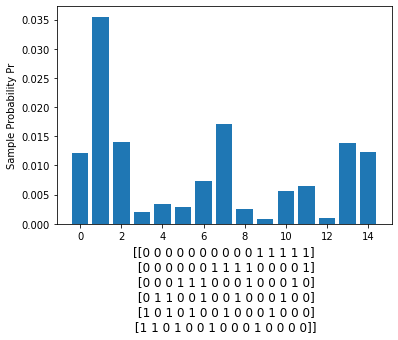

In [25]:
%%time
plt.bar(xaxis,Pn)
plt.xlabel(np.transpose(np.array(ln)), fontsize=12);
plt.ylabel('Sample Probability Pr');
plt.savefig('BosonSamplingExample6.pdf', format='pdf', bbox_inches='tight')

Probability of the photon patterns
Sampling patters are indicate in the labels.

In [26]:
print(Pn)

[0.01 0.04 0.01 0.   0.   0.   0.01 0.02 0.   0.   0.01 0.01 0.   0.01
 0.01]


In [27]:
np.sum(Pn)

0.13690671

# Compute the statistical probability of pairs

In [28]:
%%time
nmax = 2 # number of couples
probn=np.zeros([nmax+1,], dtype=np_real)
for j in range(nmax+1):
    photon_number=2*j
    # generate the patterns
    ln=patterns(photon_number,nmodes)
    npattern=len(ln)
    print('Generated '+repr(npattern)+\
          ' patterns with photon number '+repr(photon_number))
    # compute probability for each pattern
    Pn=np.zeros([npattern,], dtype=np_real)
    for nbar in range(npattern):        
        Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
        print('Photons '+repr(photon_number)+' Sample '+repr(nbar+1)+\
              ' of '+repr(npatterns)+' Pr=' +repr(Pn[nbar])+\
              ' pattern '+repr(ln[nbar]))
    # sum the probability of each pattern
    probn[j]=sum(Pn)
print('Done')

Generated 1 patterns with photon number 0
Photons 0 Sample 1 of 15 Pr=0.1257302314043045 pattern (0, 0, 0, 0, 0, 0)
Generated 15 patterns with photon number 2
Photons 2 Sample 1 of 15 Pr=0.012203296646475792 pattern (0, 0, 0, 0, 1, 1)
Photons 2 Sample 2 of 15 Pr=0.035485103726387024 pattern (0, 0, 0, 1, 0, 1)
Photons 2 Sample 3 of 15 Pr=0.01403134036809206 pattern (0, 0, 0, 1, 1, 0)
Photons 2 Sample 4 of 15 Pr=0.0020471010357141495 pattern (0, 0, 1, 0, 0, 1)
Photons 2 Sample 5 of 15 Pr=0.003311730921268463 pattern (0, 0, 1, 0, 1, 0)
Photons 2 Sample 6 of 15 Pr=0.0029368605464696884 pattern (0, 0, 1, 1, 0, 0)
Photons 2 Sample 7 of 15 Pr=0.007256839424371719 pattern (0, 1, 0, 0, 0, 1)
Photons 2 Sample 8 of 15 Pr=0.017042096704244614 pattern (0, 1, 0, 0, 1, 0)
Photons 2 Sample 9 of 15 Pr=0.0025989869609475136 pattern (0, 1, 0, 1, 0, 0)
Photons 2 Sample 10 of 15 Pr=0.0007436927407979965 pattern (0, 1, 1, 0, 0, 0)
Photons 2 Sample 11 of 15 Pr=0.005594514310359955 pattern (1, 0, 0, 0, 0, 1)


In [29]:
probn

array([0.13, 0.14, 0.02])

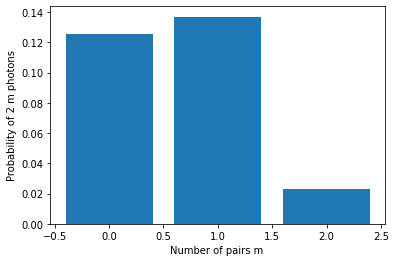

In [30]:
plt.bar(range(nmax+1),probn)
plt.ylabel('Probability of 2 m photons');
plt.xlabel('Number of pairs m ');
plt.savefig('BosonSamplingExample6ALL.pdf', format='pdf')   